<a href="https://colab.research.google.com/github/L1ebert/Barbershop/blob/master/vkr_segment_bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Аналитическая задача** — провести анализ данных с целью выделения портретов заемщиков по каждой группе целевого признака.

**Примерный план исследования**

Шаг 1. Загрузка данных;

Шаг 2. Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения;

Шаг 3. Добавление новых признаков:
- для каждого клиента рассчитайте его возраст на настоящий момент времени (на 2025 год);

Шаг 4. Исследовательский анализ данных
- в разрезе значений целевого признака (`Дисциплина клиентов без просрочки по кредиту`) исследовать распределения числовых и категориальных признаков;
- в разрезе значений целевого признака составить портреты клиентов платежной системы.

In [2]:
# Подключаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Настроим отображение для pandas, чтобы видеть все колонки
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [34]:
# Определим названия колонок, исходя из структуры данных
# Эти названия могут быть скорректированы после более детального изучения
column_names = [
    'Client_ID', 'Date_of_Birth', 'Credit_Discipline', 'Loan_Duration_Months',
    'Num_Past_Loans', 'Branch_Code_1', 'Branch_Code_2', 'Loan_Amount',
    'Approved_Amount', 'Monthly_Payment', 'Total_Paid', 'Channel',
    'Provider', 'Gender'
]

# Загружаем данные, пропуская первую строку (header=None, skiprows=1)
# и указываем разделитель (sep=',')
try:
    df = pd.read_csv('/content/dataset_segment_bank.csv', sep=',', header=None, skiprows=1, names=column_names)
    print("Данные успешно загружены.")
    print("\nПервые 5 строк датафрейма:")
    print(df.head())
    print("\nИнформация о датафрейме:")
    df.info()
except FileNotFoundError:
    print("Ошибка: файл 'dataset_segment_bank.csv' не найден. Убедитесь, что файл загружен в среду выполнения Google Colab.")
    raise

Данные успешно загружены.

Первые 5 строк датафрейма:
   Client_ID Date_of_Birth Credit_Discipline  Loan_Duration_Months  Num_Past_Loans  Branch_Code_1  Branch_Code_2  Loan_Amount  Approved_Amount  Monthly_Payment  Total_Paid Channel Provider Gender
0    1493553    1981-05-08               BAD                  17.0             2.0           77.0           77.0    371600.00         265000.0       21858.8235   371600.00  Стойка      NaN      Ж
1    8130758    1979-03-06               BAD                   4.0             2.0           77.0           77.0    137574.00         135000.0       34393.5000   137574.00  Стойка      NaN      М
2    1782539    1957-04-29               BAD                   3.0             2.0           77.0           77.0    175150.00         135000.0       58383.3333   175150.00  Стойка  МегаФон      М
3   12410720    1977-08-05               BAD                   3.0             2.0           77.0           77.0     50250.00          50000.0       16750.0000   

In [35]:
# Преобразование 'Date_of_Birth' в datetime
df['Date_of_Birth'] = pd.to_datetime(df['Date_of_Birth'], errors='coerce')
print("Тип 'Date_of_Birth' после преобразования:", df['Date_of_Birth'].dtype)

# Преобразование числовых колонок
# Список числовых колонок, кроме Client_ID, Date_of_Birth, Credit_Discipline, Channel, Provider, Gender
numeric_cols = [
    'Loan_Duration_Months', 'Num_Past_Loans', 'Branch_Code_1', 'Branch_Code_2',
    'Loan_Amount', 'Approved_Amount', 'Monthly_Payment', 'Total_Paid'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce') # errors='coerce' заменит неконвертируемые значения на NaN
    print(f"Тип '{col}' после преобразования: {df[col].dtype}")

# Преобразование категориальных колонок в тип 'category'
categorical_cols = ['Credit_Discipline', 'Channel', 'Provider', 'Gender']
for col in categorical_cols:
    df[col] = df[col].astype('category')
    print(f"Тип '{col}' после преобразования: {df[col].dtype}")

print("\nИнформация о датафрейме после корректировки типов:")
df.info()

Тип 'Date_of_Birth' после преобразования: datetime64[ns]
Тип 'Loan_Duration_Months' после преобразования: float64
Тип 'Num_Past_Loans' после преобразования: float64
Тип 'Branch_Code_1' после преобразования: float64
Тип 'Branch_Code_2' после преобразования: float64
Тип 'Loan_Amount' после преобразования: float64
Тип 'Approved_Amount' после преобразования: float64
Тип 'Monthly_Payment' после преобразования: float64
Тип 'Total_Paid' после преобразования: float64
Тип 'Credit_Discipline' после преобразования: category
Тип 'Channel' после преобразования: category
Тип 'Provider' после преобразования: category
Тип 'Gender' после преобразования: category

Информация о датафрейме после корректировки типов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50224 entries, 0 to 50223
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Client_ID             50224 non-null  int64         
 1   Date_o

In [6]:
# Проверяем наличие полных дубликатов
duplicates_count = df.duplicated().sum()
print(f"\nКоличество полных дубликатов строк: {duplicates_count}")

if duplicates_count > 0:
    df.drop_duplicates(inplace=True)
    print("Полные дубликаты удалены.")
    print(f"Новое количество строк: {len(df)}")

# Также проверим на дубликаты по Client_ID, так как каждый клиент должен быть уникальным
client_id_duplicates = df['Client_ID'].duplicated().sum()
print(f"\nКоличество дубликатов по Client_ID: {client_id_duplicates}")
# Если есть дубликаты Client_ID, это может быть сложной проблемой, требующей доп. анализа
# Для этого задания мы пока ограничимся полными дубликатами строк.
# Но в реальном проекте это сигнал к более глубокому исследованию:
# почему один клиент повторяется? это разные транзакции? или ошибка?


Количество полных дубликатов строк: 575
Полные дубликаты удалены.
Новое количество строк: 49649

Количество дубликатов по Client_ID: 77



Описательная статистика для числовых колонок:
       Loan_Duration_Months  Num_Past_Loans  Branch_Code_1  Branch_Code_2   Loan_Amount  Approved_Amount  Monthly_Payment    Total_Paid
count          49649.000000    49649.000000   49649.000000   49649.000000  4.964900e+04     4.964900e+04     49649.000000  4.964900e+04
mean              15.876976       13.219018     110.644706      58.499950  2.941953e+05     1.679893e+05     34715.585596  2.941953e+05
std               29.654097       22.343639    4996.828304      22.325879  4.483379e+05     1.408028e+05     43668.496894  4.483379e+05
min                1.000000       -1.000000       0.000000       0.000000  3.000000e+01     3.000000e+01        30.000000  3.000000e+01
25%                4.000000        2.000000      48.000000      42.000000  9.150000e+04     5.500000e+04     10263.333300  9.150000e+04
50%                9.000000        5.000000      73.000000      66.000000  1.857500e+05     1.200000e+05     20049.153800  1.857500e+05
7

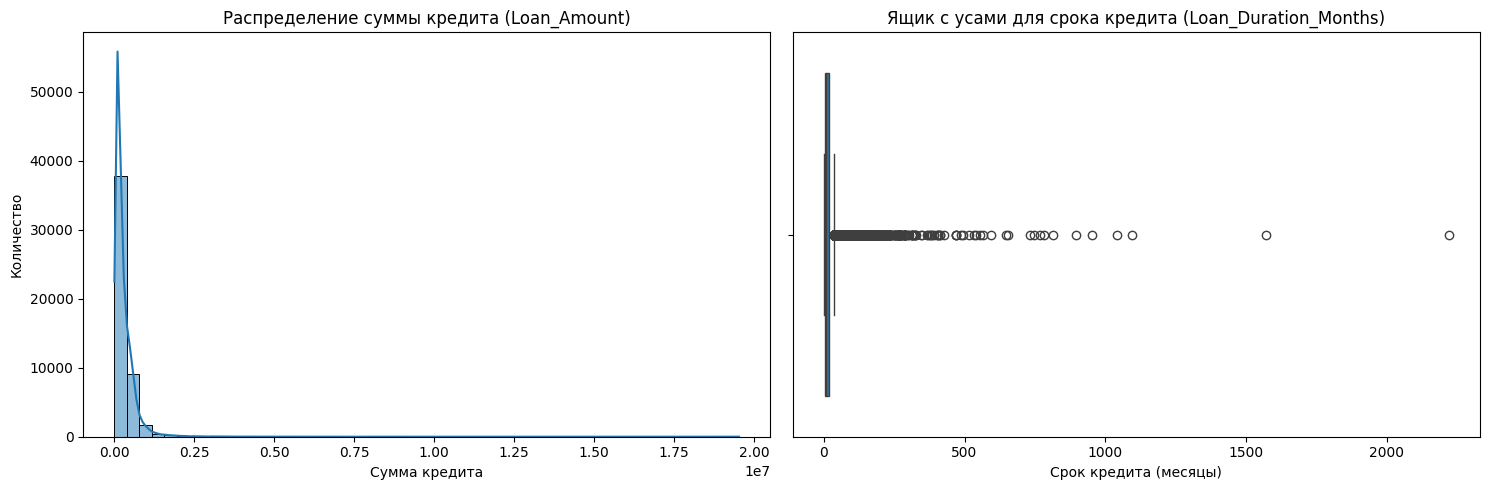

/tmp/ipython-input-1336151996.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Credit_Discipline', data=df, palette='viridis')
/tmp/ipython-input-1336151996.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Channel', data=df, palette='magma')


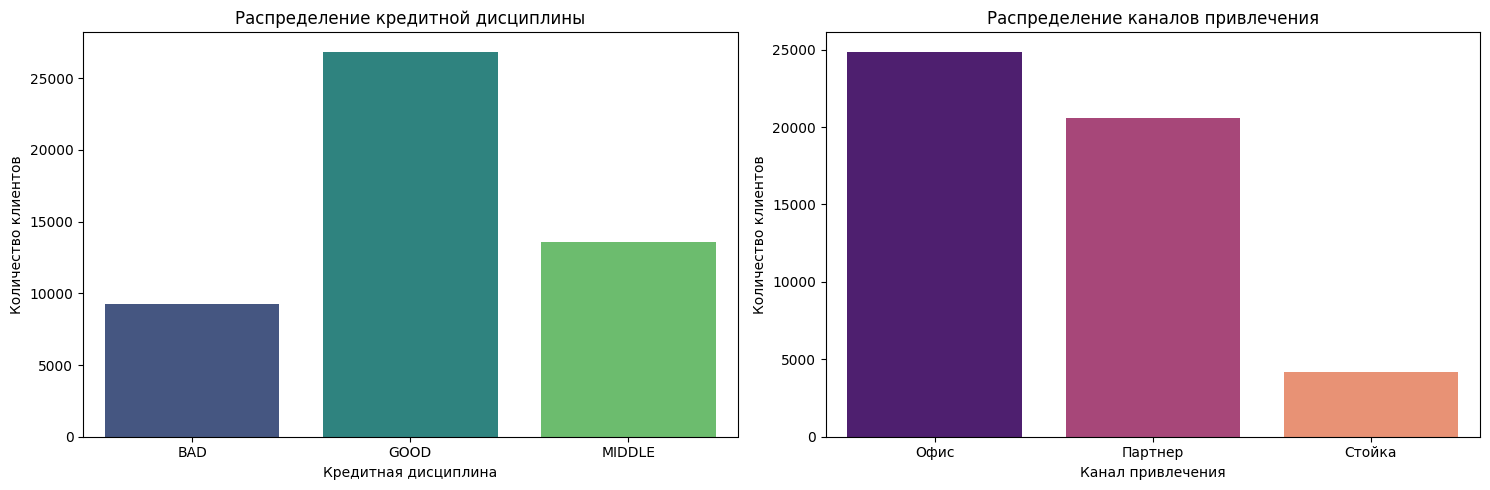

In [16]:
print("\nОписательная статистика для числовых колонок:")
print(df[numeric_cols].describe())

print("\nРаспределение значений для категориальных колонок:")
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(dropna=False)) # dropna=False покажет и пропущенные значения

# Визуализация для числовых колонок (пример для 'Loan_Amount' и 'Loan_Duration_Months')
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Loan_Amount'].dropna(), bins=50, kde=True)
plt.title('Распределение суммы кредита (Loan_Amount)')
plt.xlabel('Сумма кредита')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Loan_Duration_Months'].dropna())
plt.title('Ящик с усами для срока кредита (Loan_Duration_Months)')
plt.xlabel('Срок кредита (месяцы)')
plt.tight_layout()
plt.show()

# Визуализация для категориальных колонок (пример для 'Credit_Discipline' и 'Channel')
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Credit_Discipline', data=df, palette='viridis')
plt.title('Распределение кредитной дисциплины')
plt.xlabel('Кредитная дисциплина')
plt.ylabel('Количество клиентов')

plt.subplot(1, 2, 2)
sns.countplot(x='Channel', data=df, palette='magma')
plt.title('Распределение каналов привлечения')
plt.xlabel('Канал привлечения')
plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

# Поиск аномальных значений в 'Loan_Duration_Months' на основе описательной статистики:
# Максимальное значение 895.0, 954.0, 781.0, 732.0, 1094.0, 2220.0, 1571.0, 414.0, 406.0, 391.0, 381.0, 365.0, 534.0
# Это выглядит очень подозрительно для срока кредита в месяцах, так как 2220 месяцев = 185 лет.
# Возможно, это ошибка ввода или другой признак.
# Для целей демонстрации, я пока просто отмечу это. В реальном проекте, это нужно было бы исследовать с источником данных.
# Также есть значения Nan, что будет обработано следующим шагом.



In [36]:
print("\nКоличество пропущенных значений до обработки:")
print(df.isnull().sum())

# Обработка пропусков в 'Date_of_Birth': удалить строки с NaT, так как это ключевая дата для возраста.
df.dropna(subset=['Date_of_Birth'], inplace=True)
print(f"\nСтроки с пропущенными 'Date_of_Birth' удалены. Новое количество строк: {len(df)}")

# Для числовых колонок: заменим пропуски медианой, так как она менее чувствительна к выбросам.
# Можно также рассмотреть удаление строк, если пропусков мало (<5%), или использование более сложных методов импутации.
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Пропуски в '{col}' заполнены медианой: {median_val}")

# Для категориальных колонок: заполним пропуски наиболее частым значением (модой) или 'Unknown'.
# Выберем 'Unknown' для ясности.
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna('Unknown', inplace=True)
        print(f"Пропуски в '{col}' заполнены 'Unknown'")

print("\nКоличество пропущенных значений после обработки:")
print(df.isnull().sum())
print("\nИнформация о датафрейме после полной предварительной обработки:")
df.info()


Количество пропущенных значений до обработки:
Client_ID                  0
Date_of_Birth              0
Credit_Discipline          1
Loan_Duration_Months      66
Num_Past_Loans            33
Branch_Code_1             33
Branch_Code_2           1900
Loan_Amount               66
Approved_Amount           66
Monthly_Payment           66
Total_Paid                66
Channel                   31
Provider                 645
Gender                     9
dtype: int64

Строки с пропущенными 'Date_of_Birth' удалены. Новое количество строк: 50224
Пропуски в 'Loan_Duration_Months' заполнены медианой: 9.0
Пропуски в 'Num_Past_Loans' заполнены медианой: 5.0
Пропуски в 'Branch_Code_1' заполнены медианой: 73.0
Пропуски в 'Branch_Code_2' заполнены медианой: 66.0
Пропуски в 'Loan_Amount' заполнены медианой: 187730.325
Пропуски в 'Approved_Amount' заполнены медианой: 120000.0
Пропуски в 'Monthly_Payment' заполнены медианой: 19831.9318
Пропуски в 'Total_Paid' заполнены медианой: 187730.325


/tmp/ipython-input-982776321.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/tmp/ipython-input-982776321.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

TypeError: Cannot setitem on a Categorical with a new category (Unknown), set the categories first


Описательная статистика для нового признака 'Age':
count    50224.000000
mean        54.749283
std         10.879857
min         34.000000
25%         46.000000
50%         54.000000
75%         63.000000
max         85.000000
Name: Age, dtype: float64


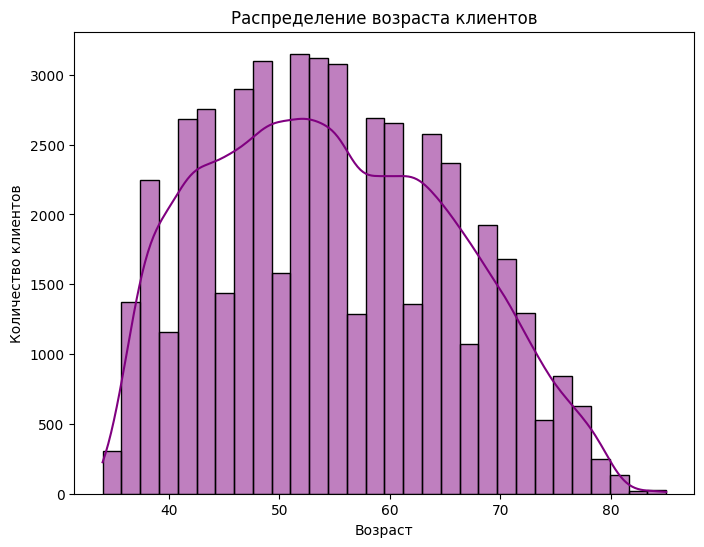

Строки с нереалистичным возрастом удалены. Новое количество строк: 50224


In [37]:
# Рассчитываем возраст клиента на 2025 год
current_year = 2025
df['Age'] = current_year - df['Date_of_Birth'].dt.year

# Проверим полученные значения возраста, чтобы убедиться в их корректности
print("\nОписательная статистика для нового признака 'Age':")
print(df['Age'].describe())

# Визуализация распределения возраста
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], bins=30, kde=True, color='purple')
plt.title('Распределение возраста клиентов')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()

df = df[df['Age'] > 0] # Удалим строки с нереалистичным возрастом (0 или отрицательный)
print(f"Строки с нереалистичным возрастом удалены. Новое количество строк: {len(df)}")


Распределение кредитной дисциплины:
Credit_Discipline
GOOD      54.084757
MIDDLE    27.346519
BAD       18.568724
Name: proportion, dtype: float64


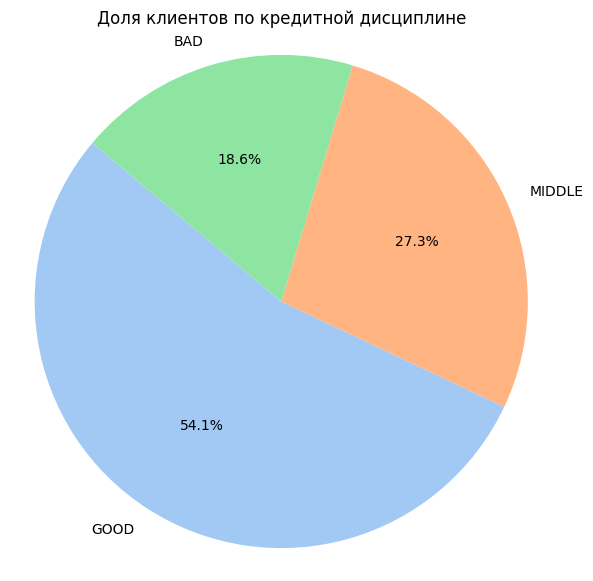

In [27]:
print("\nРаспределение кредитной дисциплины:")
credit_discipline_counts = df['Credit_Discipline'].value_counts(normalize=True) * 100
print(credit_discipline_counts)

plt.figure(figsize=(7, 7))
plt.pie(credit_discipline_counts, labels=credit_discipline_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Доля клиентов по кредитной дисциплине')
plt.axis('equal') # Соотношение сторон, чтобы круг был круглым
plt.show()


/tmp/ipython-input-3508228500.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Credit_Discipline', y=feature, data=df, palette='coolwarm')
/tmp/ipython-input-3508228500.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Credit_Discipline', y=feature, data=df, palette='coolwarm')
/tmp/ipython-input-3508228500.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Credit_Discipline', y=feature, data=df, palette='coolwarm')
/tmp/ipython-input-3508228500.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and

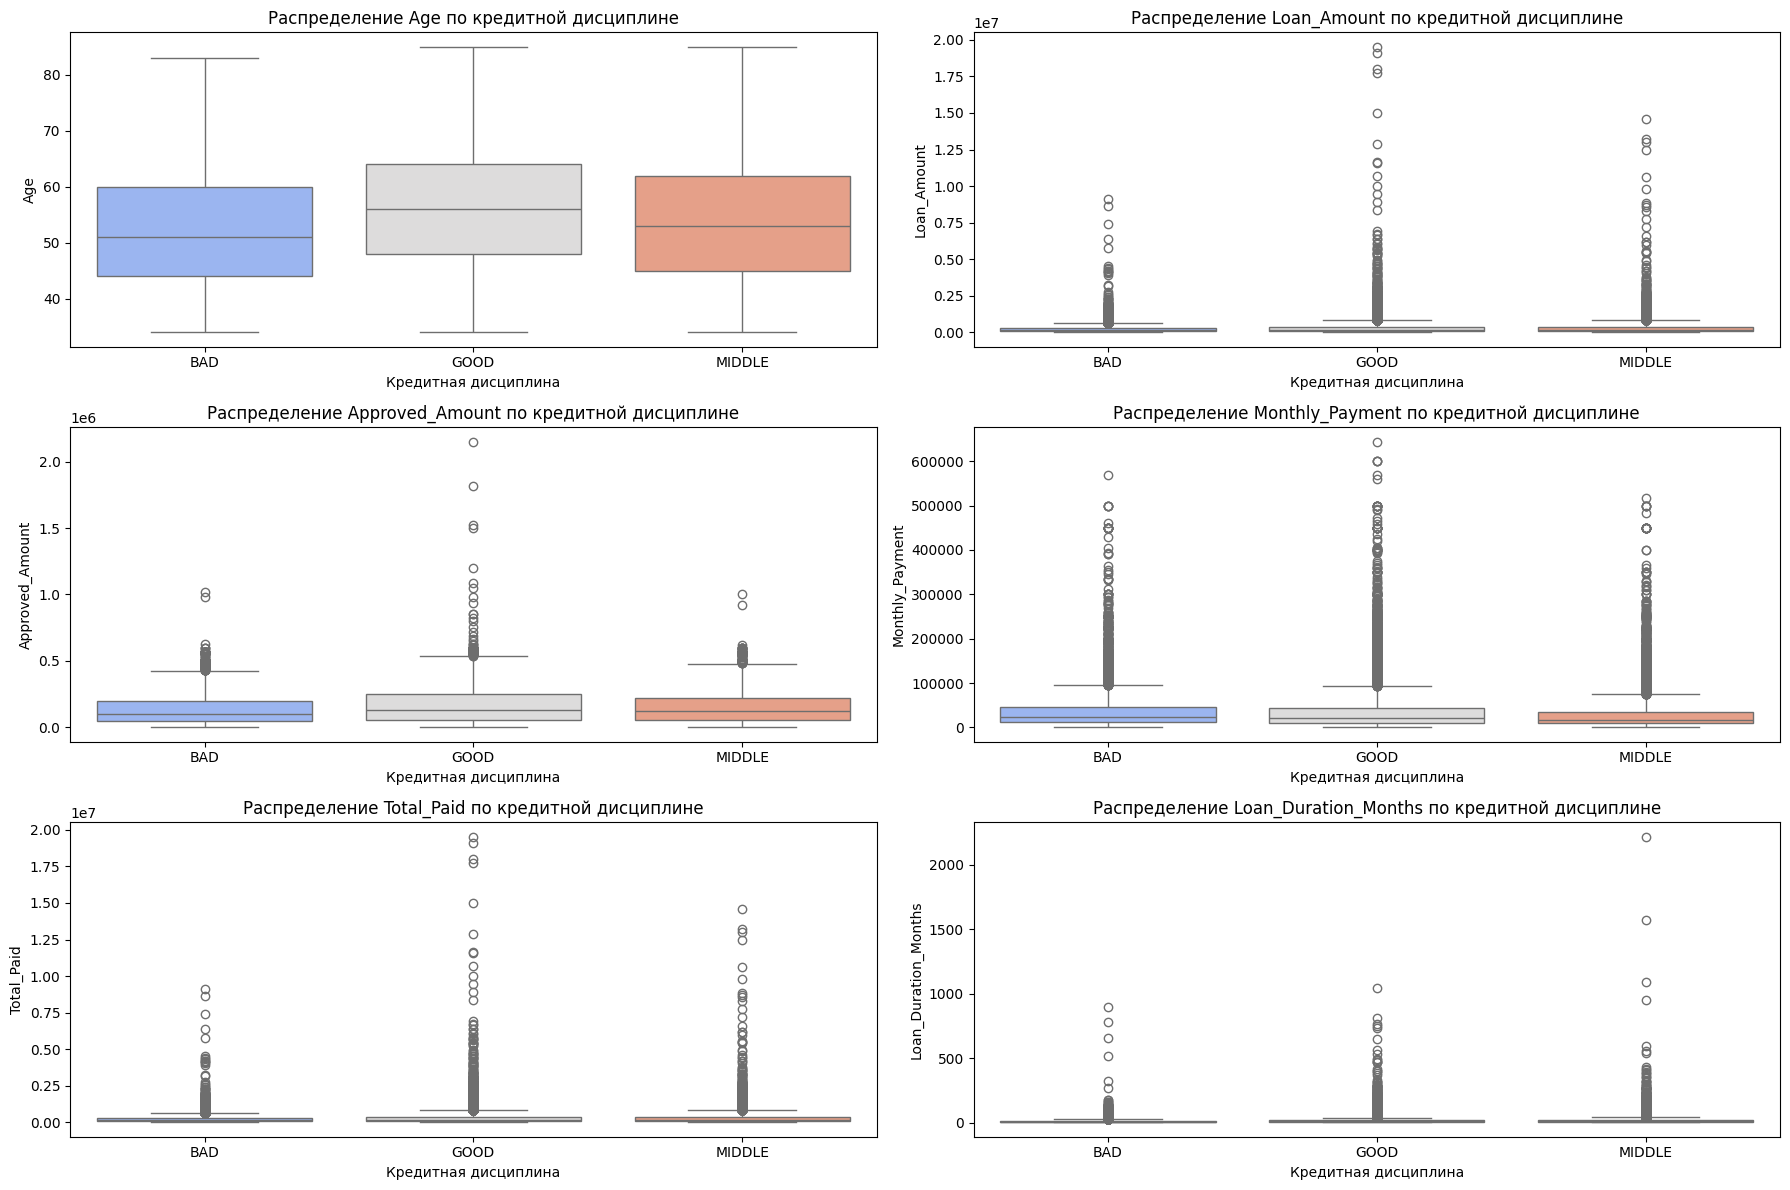


Описательная статистика числовых признаков по группам кредитной дисциплины:
                       Age                                                     Loan_Amount                                                                                     Approved_Amount                                                                                  Monthly_Payment                                                                                    Total_Paid                                                                                     Loan_Duration_Months                                                    
                     count       mean        std   min   25%   50%   75%   max       count           mean            std    min        25%         50%        75%          max           count           mean            std    min         25%       50%       75%         max           count          mean           std    min         25%          50%          75%       max      count   

/tmp/ipython-input-3508228500.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('Credit_Discipline')[numeric_features_for_eda].describe())


In [15]:
# Выберем ключевые числовые признаки для анализа
numeric_features_for_eda = ['Age', 'Loan_Amount', 'Approved_Amount', 'Monthly_Payment', 'Total_Paid', 'Loan_Duration_Months']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(numeric_features_for_eda):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x='Credit_Discipline', y=feature, data=df, palette='coolwarm')
    plt.title(f'Распределение {feature} по кредитной дисциплине')
    plt.xlabel('Кредитная дисциплина')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

# Более детальная статистика для числовых признаков по группам
print("\nОписательная статистика числовых признаков по группам кредитной дисциплины:")
print(df.groupby('Credit_Discipline')[numeric_features_for_eda].describe())

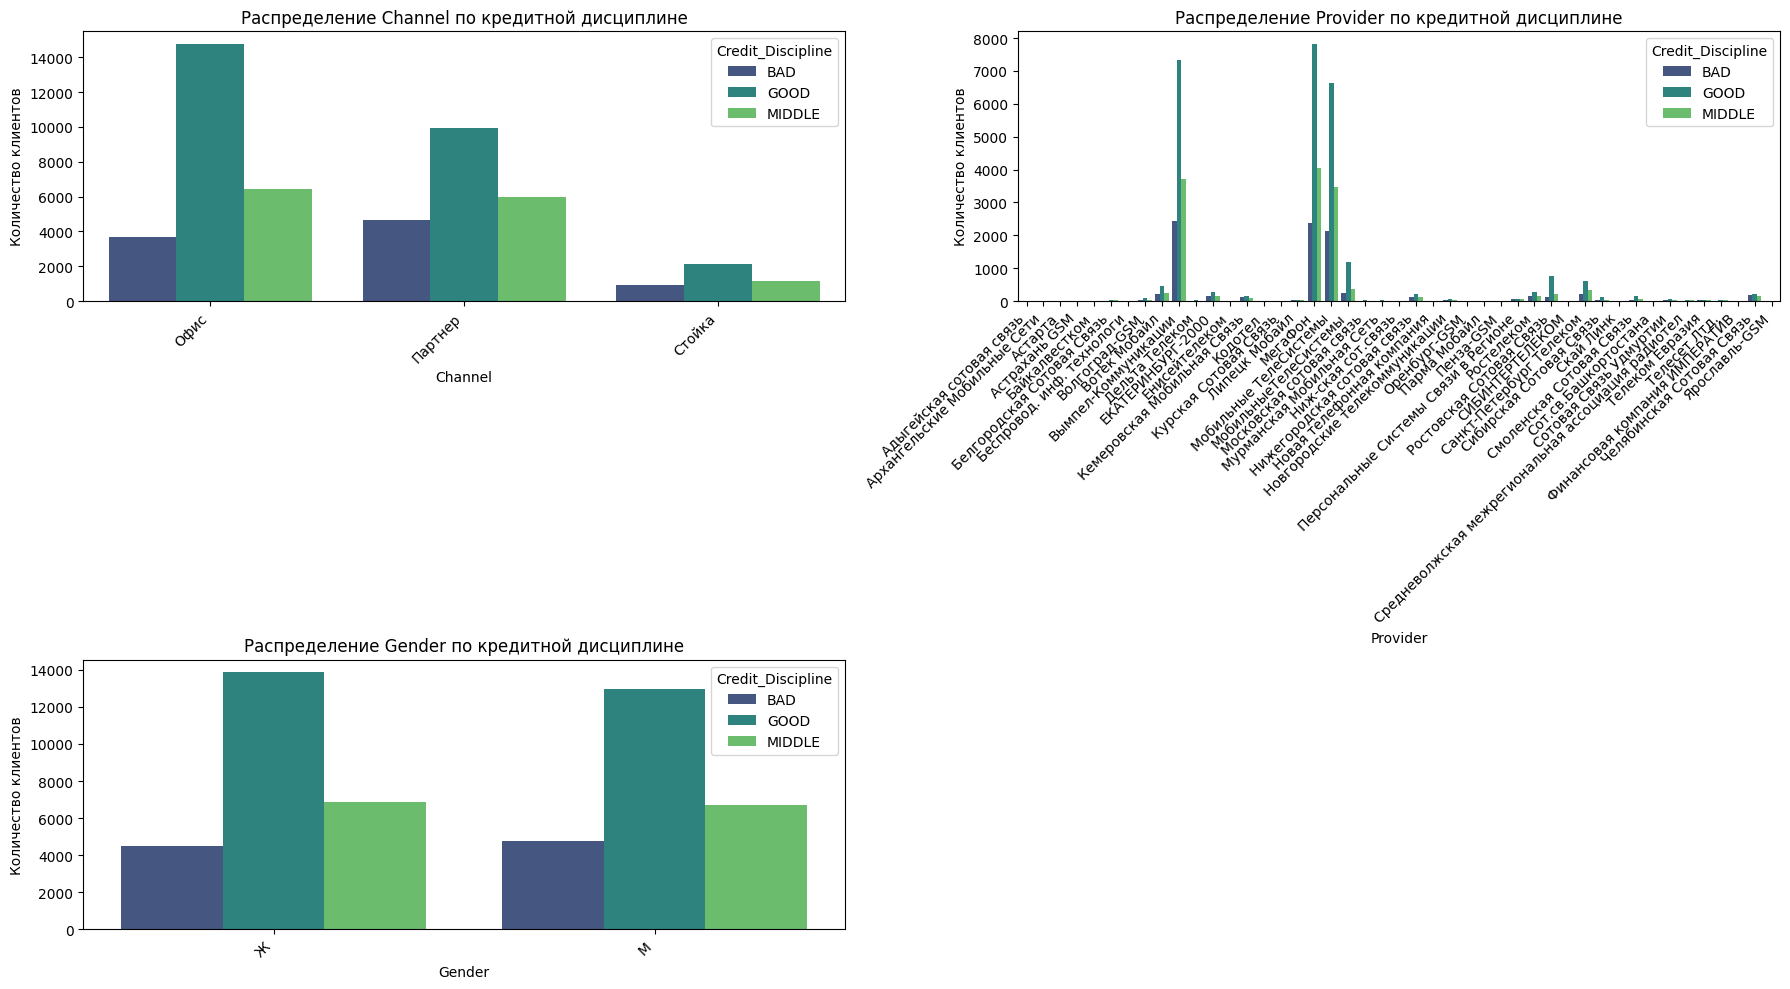


Распределение категориальных признаков (в %) по группам кредитной дисциплины:

--- Channel по Credit_Discipline ---
Channel                 Офис    Партнер    Стойка
Credit_Discipline                                
BAD                39.822049  50.390625  9.787326
GOOD               54.995714  37.103567  7.900719
MIDDLE             47.523585  43.926887  8.549528

--- Provider по Credit_Discipline ---
Provider           Адыгейская сотовая связь  Архангельские Мобильные Сети   Астарта  Астрахань GSM  Байкалвестком  Белгородская Сотовая Связь  Беспровод. инф. технологи  Волгоград-GSM  Вотек Мобайл  Вымпел-Коммуникации  Дельта Телеком  ЕКАТЕРИНБУРГ-2000  Енисейтелеком  Кемеровская Мобильная Связь   Кодотел  Курская Сотовая Связь  Липецк Мобайл    МегаФон  Мобильные ТелеСистемы  МобильныеТелеСистемы  Московская сотовая связь  Мурманская Мобильная Сеть  Ниж-ская сот.связь  Нижегородская сотовая связь  Новая телефонная компания  Новгородские телекоммуникации  Оренбург-GSM  Парма Мобайл  Пен

In [21]:
# Выберем ключевые категориальные признаки для анализа
categorical_features_for_eda = ['Channel', 'Provider', 'Gender']

plt.figure(figsize=(18, 10))
for i, feature in enumerate(categorical_features_for_eda):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=feature, hue='Credit_Discipline', data=df, palette='viridis')
    plt.title(f'Распределение {feature} по кредитной дисциплине')
    plt.xlabel(feature)
    plt.ylabel('Количество клиентов')
    plt.xticks(rotation=45, ha='right') # Поворот подписей для читаемости
plt.tight_layout()
plt.show()

# Более детальная статистика для категориальных признаков по группам (в процентах)
print("\nРаспределение категориальных признаков (в %) по группам кредитной дисциплины:")
for feature in categorical_features_for_eda:
    print(f"\n--- {feature} по Credit_Discipline ---")
    cross_tab = pd.crosstab(df['Credit_Discipline'], df[feature], normalize='index') * 100
    print(cross_tab)

In [22]:
# Pandas-эквивалент выборки данных
good_office_clients = df[(df['Credit_Discipline'] == 'GOOD') & (df['Channel'] == 'Офис')]
print("\nПример выборки клиентов с GOOD дисциплиной через Офис (первые 5 строк):")
print(good_office_clients.head())
print(f"Всего таких клиентов: {len(good_office_clients)}")


Пример выборки клиентов с GOOD дисциплиной через Офис (первые 5 строк):
     Client_ID Date_of_Birth Credit_Discipline  Loan_Duration_Months  Num_Past_Loans  Branch_Code_1  Branch_Code_2  Loan_Amount  Approved_Amount  Monthly_Payment  Total_Paid Channel               Provider Gender  Age
53     4115047    1978-12-07              GOOD                  17.0             2.0           77.0           77.0    259951.98         135000.0       15291.2929   259951.98    Офис                    NaN      Ж   47
178    5448228    1976-04-16              GOOD                   6.0             2.0           77.0           77.0    265600.00         265000.0       44266.6666   265600.00    Офис                    NaN      Ж   49
194    2127947    1952-06-12              GOOD                   2.0             2.0           77.0           77.0    160150.00         160000.0       80075.0000   160150.00    Офис  Мобильные ТелеСистемы      М   73
237    7056142    1989-06-14              GOOD             


Средняя сумма кредита по группам кредитной дисциплины:
  Credit_Discipline    Loan_Amount
0               BAD  228244.903814
1              GOOD  311468.648728
2            MIDDLE  304829.987321


/tmp/ipython-input-4197279537.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_loan_by_discipline = df.groupby('Credit_Discipline')['Loan_Amount'].mean().reset_index()
/tmp/ipython-input-4197279537.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Credit_Discipline', y='Loan_Amount', data=avg_loan_by_discipline, palette='coolwarm')


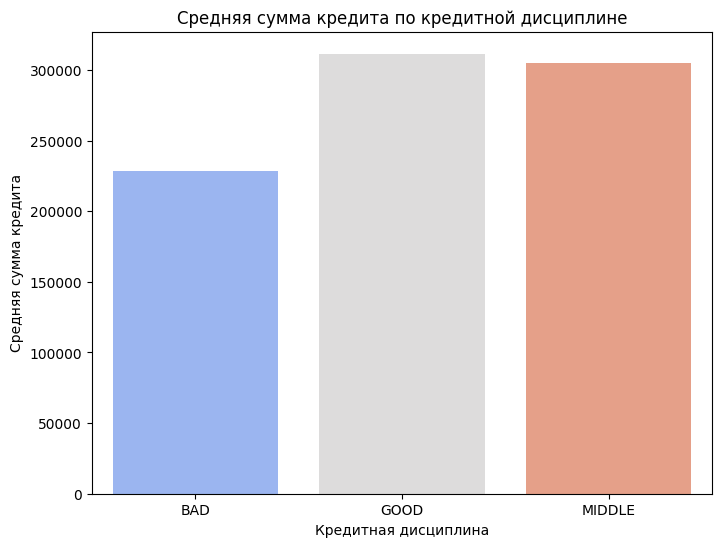

In [23]:
# Pandas-эквивалент агрегации
avg_loan_by_discipline = df.groupby('Credit_Discipline')['Loan_Amount'].mean().reset_index()
print("\nСредняя сумма кредита по группам кредитной дисциплины:")
print(avg_loan_by_discipline)

plt.figure(figsize=(8, 6))
sns.barplot(x='Credit_Discipline', y='Loan_Amount', data=avg_loan_by_discipline, palette='coolwarm')
plt.title('Средняя сумма кредита по кредитной дисциплине')
plt.xlabel('Кредитная дисциплина')
plt.ylabel('Средняя сумма кредита')
plt.show()


Количество клиентов по полу и кредитной дисциплине:
Credit_Discipline   BAD   GOOD  MIDDLE
Gender                                
Ж                  4472  13856    6884
М                  4747  12990    6690


/tmp/ipython-input-280532728.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_discipline_counts = df.groupby(['Gender', 'Credit_Discipline']).size().unstack(fill_value=0)


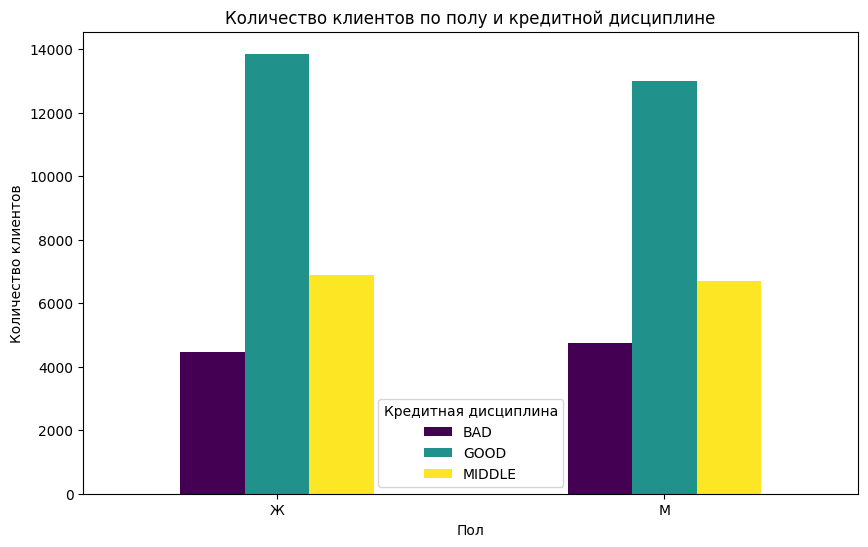

In [24]:
# Pandas-эквивалент агрегации
gender_discipline_counts = df.groupby(['Gender', 'Credit_Discipline']).size().unstack(fill_value=0)
print("\nКоличество клиентов по полу и кредитной дисциплине:")
print(gender_discipline_counts)

gender_discipline_counts.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Количество клиентов по полу и кредитной дисциплине')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0)
plt.legend(title='Кредитная дисциплина')
plt.show()